## Setup

In [42]:
# Verify we are using our virtual enviorment
!which python3
!which pip3

/Users/carnett/apps/python-virtual-environments/food_classification/bin/python3
/Users/carnett/apps/python-virtual-environments/food_classification/bin/pip3


In [43]:
# Install our dependencies
!pip3 install numpy pandas tensorflow-gpu==2.0.0-beta1 kaggle

  ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-beta1 (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-beta1
You should consider upgrading via the 'pip install --upgrade pip' command.


In [44]:
# Download our data
# !kaggle datasets download -d kmader/food41 --force

# !unzip food41/images.zip -d food41/images

In [2]:
import pandas as pd
import tensorflow as tf
import os
import IPython.display as display
import random
import pathlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [46]:
# Comment this section out if you are not using a GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Data Loading

In [49]:
data_root = pathlib.Path('/Users/carnett/apps/food_classification/food41/images')
AUTOTUNE = tf.data.experimental.AUTOTUNE
def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

In [50]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print(image_count)
DATASET_SIZE = image_count

101000


In [51]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))

all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [68, 31, 47, 60, 31, 95, 96, 87, 80, 79]


In [52]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [53]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [64, 64])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [54]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [55]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

onion_rings
donuts
gnocchi
lobster_bisque
donuts
sushi
tacos
scallops
pulled_pork_sandwich
prime_rib


In [56]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [57]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
print(ds)
# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>


<MapDataset shapes: ((64, 64, 3), ()), types: (tf.float32, tf.int32)>

In [58]:
train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

train_dataset = image_label_ds.take(train_size)
test_dataset = image_label_ds.take(test_size)


print(train_dataset)

<TakeDataset shapes: ((64, 64, 3), ()), types: (tf.float32, tf.int32)>


In [59]:
ts = test_dataset.batch(32)
ts

<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

In [48]:
BATCH_SIZE = 64

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = train_dataset.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

## Training

In [49]:
model = tf.keras.applications.resnet50.ResNet50(weights=None, input_shape=(64, 64, 3), classes=101)

W0811 02:31:15.205162 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.iter
W0811 02:31:15.207215 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_1
W0811 02:31:15.208733 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_2
W0811 02:31:15.210212 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.decay
W0811 02:31:15.211802 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.learning_rate
W0811 02:31:15.212513 140399753807680 util.py:252] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/checkpoints#

In [50]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [51]:
len(model.trainable_variables)

214

In [52]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

1579.0

In [53]:
model.fit(ds, epochs=21, shuffle=False, steps_per_epoch=steps_per_epoch)

Epoch 1/21


W0811 02:33:30.383482 140399753807680 deprecation.py:323] From /home/collin/.virtualenvs/food_classification/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1579/1579 [==============================] - 502s 318ms/step - loss: 4.6141 - accuracy: 0.0441
Epoch 2/21
1579/1579 [==============================] - 347s 220ms/step - loss: 4.4512 - accuracy: 0.0611
Epoch 3/21
1579/1579 [==============================] - 349s 221ms/step - loss: 4.2824 - accuracy: 0.0849
Epoch 4/21
1579/1579 [==============================] - 355s 225ms/step - loss: 4.2649 - accuracy: 0.0919
Epoch 5/21
1579/1579 [==============================] - 349s 221ms/step - loss: 3.9941 - accuracy: 0.1172
Epoch 6/21
1579/1579 [==============================] - 351s 222ms/step - loss: 3.6088 - accuracy: 0.1608
Epoch 7/21
1579/1579 [==============================] - 337s 214ms/step - loss: 3.4837 - accuracy: 0.1815
Epoch 8/21
1579/1579 [==============================] - 359s 227ms/step - loss: 3.2866 - accuracy: 0.2149
Epoch 9/21
1579/1579 [==============================] - 356s 225ms/step - loss: 3.0728 - accuracy: 0.2554
Epoch 10/21
1579/1579 [==============================] - 

In [55]:
model.save_weights('weights_attempt_3')

In [56]:
import time
saved_model_path = "./saved_models/{}".format(int(time.time()))

tf.keras.experimental.export_saved_model(model, saved_model_path)
saved_model_path

W0811 04:37:21.911157 140399753807680 deprecation.py:323] From /home/collin/.virtualenvs/food_classification/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0811 04:37:21.913411 140399753807680 export_utils.py:182] Export includes no default signature!
W0811 04:37:27.412421 140399753807680 export_utils.py:182] Export includes no default signature!


'./saved_models/1565498227'

## Evaluation

In [4]:
model = tf.keras.experimental.load_from_saved_model('./saved_models/1565476483')

In [21]:
img = mpimg.imread('cheesecake.jpg')

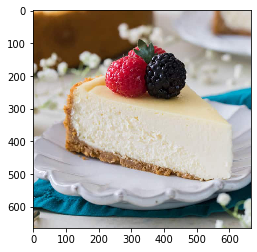

In [22]:
imgplot = plt.imshow(img)

In [30]:
img = load_and_preprocess_image('cheesecake.jpg')
type(img)

tensorflow.python.framework.ops.EagerTensor

In [33]:
img = tf.reshape(img, [1,64,64,3])

In [38]:
predictions = model.predict(img)

In [39]:
results = np.argmax(predictions, axis=1) 

In [41]:
results[0]

17

In [72]:
food_dict = {} 
for key, value in label_to_index.items(): 
   if value in food_dict: 
       food_dict[value].append(key) 
   else: 
       food_dict[value]=[key] 

print(food_dict[results[0]][0])

cheesecake


## Export

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [6]:
open('resnet50_food101_classifier.tflite', 'wb').write(tflite_model)

94778368

In [7]:
!ls

Food1.ipynb                           weights.data-00001-of-00002
Untitled.ipynb                        weights.index
checkpoint                            weights_attempt_2.data-00000-of-00002
cheesecake.jpg                        weights_attempt_2.data-00001-of-00002
food_classification_old.ipynb         weights_attempt_2.index
food_classifier.ipynb                 weights_attempt_3.data-00000-of-00002
resnet50_food101_classifier.tflite    weights_attempt_3.data-00001-of-00002
saved_models                          weights_attempt_3.index
weights.data-00000-of-00002
